In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sy
from scipy.linalg import block_diag
import scipy.stats as st
from scipy.signal import butter, lfilter, freqz


from datetime import *
from dateutil import *
try:
    from control import *
    from control import matlab
    from matplotlib.pyplot import *
    from pandas import *
    from numpy import *
except:
    import pip
    pip.main("install control matplotlib numpy pandas slycot".split())
    raise Exception("try again")

Function to read csv file:


In [2]:
def NA(x):
    try:
        return round(float(x),1)
    except:
        return float('NAN')
def timestamp(x):
    return datetime.strptime(x,"%m/%d/%y %H:%M")
def timestamp2(x):
    return datetime.strptime(x,"%Y-%m-%d %H:%M:%S")

def read_file(power_file_csv, weather_file_csv):
    
    # Load data + Choose columns + NA points filling
    feeder_power = pd.read_csv(power_file_csv, converters = {"timestamp": timestamp, "feeder_power": NA})
    feeder_weather = pd.read_csv(weather_file_csv, converters = { "datetime": timestamp2,
                                                                 "heat_index[degF]": NA, 
                                                                "solar_global[W/sf]": NA},
                            usecols = ["datetime","heat_index[degF]", "solar_global[W/sf]"],
                            keep_default_na = False,
                            index_col = ["datetime"])
    
    # Take the average of all 5min points into hourly interval
    index = list(map(lambda t:datetime(t.year,t.month,t.day,t.hour),DatetimeIndex(feeder_power.timestamp)))
    power = feeder_power.groupby(index).feeder_power.mean()
    
    # Combine weather and power data using datatime index and drop NA
    index1 = list(map(lambda t:datetime(t.year,t.month,t.day,t.hour),feeder_weather.index))
    feeder = feeder_weather.groupby(index1).mean().join(power.round(1)).dropna()
    feeder.columns = ["solar","temperature","power"]
    feeder.index.name = "datetime"
    
    return feeder
    
feeder = read_file('feeder_power.csv','feeder_weather.csv')
feeder

,solar,temperature,power
datetime,,,
2014-10-01 00:00:00,0.0,47.8,1747.5
2014-10-01 01:00:00,0.0,47.8,1669.7
2014-10-01 02:00:00,0.0,47.8,1621.8
2014-10-01 03:00:00,0.0,47.8,1629.3
2014-10-01 04:00:00,0.0,47.8,1692.5
...,...,...,...
2017-09-30 19:00:00,0.0,49.7,2205.2
2017-09-30 20:00:00,0.0,49.7,2151.1
2017-09-30 21:00:00,0.0,49.7,2060.0


In [3]:
# Determining the base mean temperature to minimize slope

def get_baseload(data,
        power_name,
        temperature_name,
        Tbase = 'auto',
        Tdiff = 10,
        MaxSlope = 0.1,
        Epsilon = 0.1
        ):

    if Tbase == 'auto':
        slope_base=np.Infinity
        Tbase = 65
        n = 1
        MaxIterations = 50
        while abs(slope_base) > MaxSlope and n < MaxIterations:
            base = data[(data[temperature_name]-Tbase).abs()<=Tdiff/2]
            T = base[temperature_name]
            P = base[power_name]
            slope_base, intercept, rvalue, pvalue, stderr = st.linregress(T,P)
            #Tbase -= slope_base/n
            Tbase -= slope_base * (Epsilon/n)
            load = intercept + slope_base*Tbase
            n += 1
    else:
        base = data[(data[temperature_name]-Tbase).abs()<=Tdiff/2]
        T = base[temperature_name]
        P = base[power_name]
        slope_base, intercept, rvalue, pvalue, stderr = st.linregress(T,P)
        load = intercept + slope_base*Tbase
    return load, slope_base, Tbase, base, intercept

load, slope_base, Tbase, base, intercept = get_baseload(feeder,'power','temperature')
load_base = intercept + slope_base*base.temperature


In [4]:
# Determining slopes for heating and cooling regions
Tdiff = 10
Theat = Tbase - Tdiff/2
Tcool = Tbase + Tdiff/2

heating = feeder[feeder.temperature < Theat]
cooling = feeder[feeder.temperature > Tcool]

def get_slopes(heating,cooling,power_name,temperature_name):
    
    if not heating.empty:
        T = np.array(heating[temperature_name])
        P = np.array(heating[power_name])
        heat_slope, h0, hr, hp, hs = st.linregress(T,P)
    else:
        heat_slope = None

    if not cooling.empty:
        T = np.array(cooling[temperature_name])
        P = np.array(cooling[power_name])
        cool_slope, c0, cr, cp, cs = st.linregress(T,P)
    else:
        cool_slope = None

    return heat_slope, cool_slope, h0, c0

heat_slope, cool_slope, h0, c0 = get_slopes(heating,cooling,'power','temperature')

load_cooling = c0 + cool_slope*cooling.temperature
load_heating = h0 + heat_slope*heating.temperature



In [5]:
# Get the static and dynamic power in a time scale
for i in range(len(feeder)):
    T_i = feeder.iloc[i].temperature
    if T_i < Theat:
    # calculate static power for heating mode
        P_s = h0 + heat_slope*T_i
    elif T_i >= Tcool:
    # calculate static power for cooling mode
        P_s = c0 + cool_slope*T_i
    else: 
    # calculate static power for vent mode (flat)
        P_s = intercept + slope_base*T_i
    
    feeder.loc[feeder.index[i], 'P_static'] = P_s
    feeder.loc[feeder.index[i], 'P_residual'] = feeder['power'][i] - P_s


In [6]:
def static_dynamic_data(dataframe, power_name, temperature_name):
    
    load, slope_base, Tbase, base, intercept = get_baseload(dataframe,power_name,temperature_name)

    

    # Get the static and dynamic power in a time scale
    for i in range(len(feeder)):
        T_i = feeder.iloc[i].temperature
        if T_i < Theat:
        # calculate static power for heating mode
            P_s = h0 + heat_slope*T_i
        elif T_i > Tcool:
        # calculate static power for cooling mode
            P_s = c0 + cool_slope*T_i
        else: 
        # calculate static power for vent mode (flat)
            P_s = intercept + slope_base*T_i

        feeder.loc[feeder.index[i], 'P_static'] = P_s
        feeder.loc[feeder.index[i], 'P_residual'] = feeder['power'][i] - P_s


In [7]:
# generate M matrix for feeder for a specified model 

def M_model_0(dataframe, power, heldout_data = 0.0275,  model_order = 3):
    
    
    L = model_order
    K = len(dataframe.power)
    N = int(len(dataframe)*heldout_data)
    P = matrix(power).transpose()  
#     P_s =  matrix(dataframe.P_static).transpose()
    
    T = matrix(dataframe.temperature).transpose()
    S = matrix(dataframe.solar).transpose()
    
    M = np.hstack([np.hstack([P[n:K-L+n] for n in range(L)]),
                 np.hstack([T[n:K-L+n] for n in range(L+1)]),
                 np.hstack([S[n:K-L+n] for n in range(L+1)])])
    Mh = M[0:-N]
    Mt = Mh.transpose()
    x = np.linalg.solve(np.matmul(Mt,Mh),np.matmul(Mt,P[L:-N]))
    Q = M[-N:]*x 
#     er = ((Q+P_s[-N:])/(P[-N:]+P_s[-N:]) - 1)*100
    er = (Q/P[-N:] - 1)*100
    error = er.mean()
    std = er.std()
    
    return Q, error, M, x

Q, error, M, x = M_model_0(feeder, feeder.power, model_order = 3)

In [8]:
# generate M matrix for feeder for a model order that gives the best performance (minimizes mean error)

def M_model(dataframe, power, heldout_data = 0.0275, model_order = 'auto'):   
    
    if model_order == 'auto':
        
        Max_order = 30
        errors = []
        for i in range(1,Max_order):
            Q, error, M, x  = M_model_0(dataframe, power, heldout_data, model_order = i)
            errors.append(abs(error)) 
            
        e = np.min(errors)
        index, = np.where(errors == e)
        m_order = index + 1
        model_order = m_order.item()
        Q, error, M, x = M_model_0(dataframe, power, heldout_data, model_order = model_order)
        
    else:
        Q, error, M, x = M_model_0(dataframe, power, heldout_data, model_order)
    
    return Q, error, M, model_order, x
    


In [9]:
# Function to specify features for month's divisor, day's divisor, and hour's divisor:

def feature_selection(dataframe, months_div, days_div, hours_div):
    feeder_ind = dataframe.copy()

# month type
    
    if months_div == 12:
        feeder_ind['Jan'] = np.where(feeder_ind.index.month == 1,1,0)
        feeder_ind['Feb'] = np.where(feeder_ind.index.month == 2,1,0)
        feeder_ind['Mar'] = np.where(feeder_ind.index.month == 3,1,0)
        feeder_ind['Apr'] = np.where(feeder_ind.index.month == 4,1,0)
        feeder_ind['May'] = np.where(feeder_ind.index.month == 5,1,0)
        feeder_ind['Jun'] = np.where(feeder_ind.index.month == 6,1,0)
        feeder_ind['Jul'] = np.where(feeder_ind.index.month == 7,1,0)
        feeder_ind['Aug'] = np.where(feeder_ind.index.month == 8,1,0)
        feeder_ind['Sep'] = np.where(feeder_ind.index.month == 9,1,0)
        feeder_ind['Oct'] = np.where(feeder_ind.index.month == 10,1,0)
        feeder_ind['Nov'] = np.where(feeder_ind.index.month == 11,1,0)
        feeder_ind['Dec'] = np.where(feeder_ind.index.month == 12,1,0)
                
    elif months_div == 6:
        feeder_ind['Jan Feb'] = np.where((np.logical_or(feeder_ind.index.month==1,feeder_ind.index.month==2)),1,0)
        feeder_ind['Mar Apr'] = np.where((np.logical_or(feeder_ind.index.month==3,feeder_ind.index.month==4)),1,0)
        feeder_ind['May Jun'] = np.where((np.logical_or(feeder_ind.index.month==5,feeder_ind.index.month==6)),1,0)
        feeder_ind['Jul Aug'] = np.where((np.logical_or(feeder_ind.index.month==7,feeder_ind.index.month==8)),1,0)
        feeder_ind['Sep Oct'] = np.where((np.logical_or(feeder_ind.index.month==9,feeder_ind.index.month==10)),1,0)
        feeder_ind['Nov Dec'] = np.where((np.logical_or(feeder_ind.index.month==11,feeder_ind.index.month==12)),1,0)
        
    elif months_div == 4:
        feeder_ind['W'] = np.where((np.logical_or(np.logical_or(feeder_ind.index.month==12,feeder_ind.index.month==1),feeder_ind.index.month==2)),1,0)
        feeder_ind['Sp'] = np.where((np.logical_or(np.logical_or(feeder_ind.index.month==3,feeder_ind.index.month==4),feeder_ind.index.month==5)),1,0)
        feeder_ind['Su'] = np.where((np.logical_or(np.logical_or(feeder_ind.index.month==6,feeder_ind.index.month==7),feeder_ind.index.month==8)),1,0)
        feeder_ind['F'] = np.where((np.logical_or(np.logical_or(feeder_ind.index.month==9,feeder_ind.index.month==10),feeder_ind.index.month==11)),1,0)
        
    elif months_div == 3:
        feeder_ind['fst']= np.where(np.logical_and(feeder_ind.index.month >= 1, feeder_ind.index.month <=4),1,0)
        feeder_ind['sec']= np.where(np.logical_and(feeder_ind.index.month >= 5, feeder_ind.index.month <=8),1,0)
        feeder_ind['thr']= np.where(np.logical_and(feeder_ind.index.month >= 9, feeder_ind.index.month <=12),1,0)
        
    elif months_div == 2:
        feeder_ind['first_half']= np.where(np.logical_and(feeder_ind.index.month >= 1, feeder_ind.index.month <=6),1,0)
        feeder_ind['sec_half']= np.where(np.logical_and(feeder_ind.index.month >= 7, feeder_ind.index.month <=12),1,0)

# day type         
    
    if days_div == 2:
        feeder_ind['WD'] = np.where(feeder_ind.index.weekday < 5,1,0)
        feeder_ind['WE'] = np.where(feeder_ind.index.weekday >= 5,1,0)

    elif days_div == 7:
        feeder_ind['M'] = np.where(feeder_ind.index.weekday == 0,1,0)
        feeder_ind['Tu'] = np.where(feeder_ind.index.weekday == 1,1,0)
        feeder_ind['W'] = np.where(feeder_ind.index.weekday == 2,1,0)
        feeder_ind['Th'] = np.where(feeder_ind.index.weekday == 3,1,0)
        feeder_ind['F'] = np.where(feeder_ind.index.weekday == 4,1,0)
        feeder_ind['Sa'] = np.where(feeder_ind.index.weekday == 5,1,0)
        feeder_ind['Su'] = np.where(feeder_ind.index.weekday == 6,1,0)
           
# hour type

    if hours_div == 24:
        feeder_ind['0'] = np.where(feeder_ind.index.hour == 0,1,0)
        feeder_ind['1'] = np.where(feeder_ind.index.hour == 1,1,0)
        feeder_ind['2'] = np.where(feeder_ind.index.hour == 2,1,0)
        feeder_ind['3'] = np.where(feeder_ind.index.hour == 3,1,0)
        feeder_ind['4'] = np.where(feeder_ind.index.hour == 4,1,0)
        feeder_ind['5'] = np.where(feeder_ind.index.hour == 5,1,0)
        feeder_ind['6'] = np.where(feeder_ind.index.hour == 6,1,0)
        feeder_ind['7'] = np.where(feeder_ind.index.hour == 7,1,0)
        feeder_ind['8'] = np.where(feeder_ind.index.hour == 8,1,0)
        feeder_ind['9'] = np.where(feeder_ind.index.hour == 9,1,0)
        feeder_ind['10'] = np.where(feeder_ind.index.hour == 10,1,0)
        feeder_ind['11'] = np.where(feeder_ind.index.hour == 11,1,0)
        feeder_ind['12'] = np.where(feeder_ind.index.hour == 12,1,0)
        feeder_ind['13'] = np.where(feeder_ind.index.hour == 13,1,0)
        feeder_ind['14'] = np.where(feeder_ind.index.hour == 14,1,0)
        feeder_ind['15'] = np.where(feeder_ind.index.hour == 15,1,0)
        feeder_ind['16'] = np.where(feeder_ind.index.hour == 16,1,0)
        feeder_ind['17'] = np.where(feeder_ind.index.hour == 17,1,0)
        feeder_ind['18'] = np.where(feeder_ind.index.hour == 18,1,0)
        feeder_ind['19'] = np.where(feeder_ind.index.hour == 19,1,0)
        feeder_ind['20'] = np.where(feeder_ind.index.hour == 20,1,0)
        feeder_ind['21'] = np.where(feeder_ind.index.hour == 21,1,0)
        feeder_ind['22'] = np.where(feeder_ind.index.hour == 22,1,0)
        feeder_ind['23'] = np.where(feeder_ind.index.hour == 23,1,0)

    elif hours_div == 12:
        feeder_ind['0-1'] = np.where(np.logical_or(feeder_ind.index.hour==0,feeder_ind.index.hour==1),1,0)
        feeder_ind['2-3'] = np.where(np.logical_or(feeder_ind.index.hour==2,feeder_ind.index.hour==3),1,0)
        feeder_ind['5-5'] = np.where(np.logical_or(feeder_ind.index.hour==4,feeder_ind.index.hour==5),1,0)
        feeder_ind['6-7'] = np.where(np.logical_or(feeder_ind.index.hour==6,feeder_ind.index.hour==7),1,0)
        feeder_ind['8-9'] = np.where(np.logical_or(feeder_ind.index.hour==8,feeder_ind.index.hour==9),1,0)
        feeder_ind['10-11'] = np.where(np.logical_or(feeder_ind.index.hour==10,feeder_ind.index.hour==11),1,0)
        feeder_ind['12-13'] = np.where(np.logical_or(feeder_ind.index.hour==12,feeder_ind.index.hour==13),1,0)
        feeder_ind['14-15'] = np.where(np.logical_or(feeder_ind.index.hour==14,feeder_ind.index.hour==15),1,0)
        feeder_ind['16-17'] = np.where(np.logical_or(feeder_ind.index.hour==16,feeder_ind.index.hour==17),1,0)
        feeder_ind['18-19'] = np.where(np.logical_or(feeder_ind.index.hour==18,feeder_ind.index.hour==19),1,0)
        feeder_ind['20-21'] = np.where(np.logical_or(feeder_ind.index.hour==20,feeder_ind.index.hour==21),1,0)
        feeder_ind['22-23'] = np.where(np.logical_or(feeder_ind.index.hour==22,feeder_ind.index.hour==23),1,0)
        
    elif hours_div == 8:
        feeder_ind['0-2'] = np.where(np.logical_and(feeder_ind.index.hour >= 0, feeder_ind.index.hour <=2),1,0)
        feeder_ind['3-5'] = np.where(np.logical_and(feeder_ind.index.hour >= 3, feeder_ind.index.hour <=5),1,0)
        feeder_ind['6-8'] = np.where(np.logical_and(feeder_ind.index.hour >= 6, feeder_ind.index.hour <=8),1,0)
        feeder_ind['9-11'] = np.where(np.logical_and(feeder_ind.index.hour >= 9, feeder_ind.index.hour <=11),1,0)
        feeder_ind['12-14'] = np.where(np.logical_and(feeder_ind.index.hour >= 12, feeder_ind.index.hour <=14),1,0)
        feeder_ind['15-17'] = np.where(np.logical_and(feeder_ind.index.hour >= 15, feeder_ind.index.hour <=17),1,0)
        feeder_ind['18-20'] = np.where(np.logical_and(feeder_ind.index.hour >= 18, feeder_ind.index.hour <=20),1,0)
        feeder_ind['21-23'] = np.where(np.logical_and(feeder_ind.index.hour >= 21, feeder_ind.index.hour <=23),1,0)
        
    elif hours_div == 6:
        feeder_ind['0-3'] = np.where(np.logical_and(feeder_ind.index.hour >= 0, feeder_ind.index.hour <=3),1,0)
        feeder_ind['4-7'] = np.where(np.logical_and(feeder_ind.index.hour >= 4, feeder_ind.index.hour <=7),1,0)
        feeder_ind['8-11'] = np.where(np.logical_and(feeder_ind.index.hour >= 8, feeder_ind.index.hour <=11),1,0)
        feeder_ind['12-15'] = np.where(np.logical_and(feeder_ind.index.hour >= 12, feeder_ind.index.hour <=15),1,0)
        feeder_ind['16-19'] = np.where(np.logical_and(feeder_ind.index.hour >= 16, feeder_ind.index.hour <=19),1,0)
        feeder_ind['20-23'] = np.where(np.logical_and(feeder_ind.index.hour >= 20, feeder_ind.index.hour <=23),1,0)
        
    elif hours_div == 4:
        feeder_ind['Ni'] = np.where(np.logical_and(feeder_ind.index.hour >= 0, feeder_ind.index.hour <=5),1,0)
        feeder_ind['Mo'] = np.where(np.logical_and(feeder_ind.index.hour >= 6, feeder_ind.index.hour <=11),1,0)
        feeder_ind['Af'] = np.where(np.logical_and(feeder_ind.index.hour >= 12, feeder_ind.index.hour <=17),1,0)
        feeder_ind['Ev'] = np.where(np.logical_and(feeder_ind.index.hour >= 18, feeder_ind.index.hour <=23),1,0)
        
    elif hours_div ==3:
        feeder_ind['Ni'] = np.where(np.logical_and(feeder_ind.index.hour >= 0, feeder_ind.index.hour <=7),1,0)
        feeder_ind['Mo'] = np.where(np.logical_and(feeder_ind.index.hour >= 8, feeder_ind.index.hour <=15),1,0)
        feeder_ind['Af'] = np.where(np.logical_and(feeder_ind.index.hour >= 16, feeder_ind.index.hour <=23),1,0)
        
    elif hours_div == 2:
        feeder_ind['Ni'] = np.where(np.logical_and(feeder_ind.index.hour >= 0, feeder_ind.index.hour <=11),1,0)
        feeder_ind['Da'] = np.where(np.logical_and(feeder_ind.index.hour >= 12, feeder_ind.index.hour <=23),1,0)       
    
    return  feeder_ind



In [10]:
# function to fit model for specified features:
model_order = 3
def feature_model(dataframe, power, months_div, days_div, hours_div, heldout_data = 0.0275, model_order = model_order, M = M):
    
    feeder_ind = feature_selection(dataframe, months_div, days_div, hours_div)
    P = matrix(power).transpose()
#     P_s = matrix(dataframe.P_static).transpose()
    M_ind = matrix(feeder_ind.iloc[:,3:].values)
    N = int(len(dataframe)*heldout_data)
    M_comb = np.hstack([M,M_ind[model_order:]])
    Mh_comb = M_comb[0:-N]
    Mt_comb = Mh_comb.transpose()
    x_comb = np.linalg.solve(np.matmul(Mt_comb,Mh_comb),np.matmul(Mt_comb,P[model_order:-N]))
    Q_comb = M_comb[-N:]*x_comb
    e_comb = (Q_comb/P[-N:] - 1)*100
    filt_e = butter_lowpass_filter(e_comb.transpose().tolist()[0])
#     e_comb = ((Q_comb+P_s[-N:])/(P[-N:]+P_s[-N:]) - 1)*100

    error = e_comb.mean()
    
    return e_comb, Q_comb, error, feeder_ind, x_comb, filt_e

In [11]:
# function to choose the best features (months_div, days_div, hours_div) for best performance (minimizes mean error)

def best_feature(dataframe, power, months_div = 'auto', days_div = 'auto', hours_div = 'auto', heldout_data = 0.0275,
                 model_order = model_order, M = M):
    M_ = M
    model_ord = model_order
# find the months divisor that minimizes the error

    if months_div == 'auto':
        month_divisors = [1,2,3,4,6,12]
        errors = []
        day_div = 1
        hour_div = 1
        for i in range(0,len(month_divisors)):
            months_div = month_divisors[i]
            e_comb, Q_comb, error, feeder_ind, x_comb, filt_e = feature_model(dataframe, power, months_div, day_div,
                                                                      hour_div,heldout_data, model_ord, M_)
            errors.append(error)
        er = np.abs(errors)
        e = np.min(er)
        index, = np.where(er == e)
        months_div = month_divisors[index.item()]        
    else:
        months_div = months_div
       
 #find the days divisor that minimizes the error

    if days_div == 'auto':
        days_divisors = [1,2,7]
        errors = []
        month_div = months_div
        hour_div = 1
        for i in range(0,len(days_divisors)):
            day_div = days_divisors[i]
            e_comb, Q_comb, error, feeder_ind, x_comb, filt_e = feature_model(dataframe, power, month_div, day_div, 
                                                                      hour_div, heldout_data, model_ord, M_)
            errors.append(error)
        er = np.abs(errors)
        e = np.min(er)
        index, = np.where(er == e)
        days_div = days_divisors[index.item()]
    else:
        days_div = days_div
        
  # find the hours divisor that minimizes the error

    if hours_div == 'auto':
        hours_divisors = [1,3,4,6,8,12,24]
        errors = []
        month_div = months_div
        day_div = days_div
        for i in range(0,len(hours_divisors)):
            hour_div = hours_divisors[i]
            e_comb, Q_comb, error, feeder_ind, x_comb, filt_e = feature_model(dataframe, power, month_div, day_div, 
                                                                      hour_div, heldout_data, model_ord, M_)
            errors.append(error)
        er = np.abs(errors)
        e = np.min(er)
        index, = np.where(er == e)
        hours_div = hours_divisors[index.item()]
        
    else:
        hours_div = hours_div
     
    
    e_comb, Q_comb, error, feeder_ind, x_comb, filt_e = feature_model(dataframe, power, months_div,days_div, hours_div, heldout_data, model_ord, M_)
    
    return e_comb, Q_comb, error, feeder_ind, months_div, days_div, hours_div, x_comb, filt_e 




In [58]:
# function that does all the plotting for the model fitted with the held out data 

def plot_model(dataframe, power, e_comb, filt_e, Q_comb, heldout_data):
    
    N = int(len(dataframe)*heldout_data)
    P = matrix(power).transpose()
    T = matrix(dataframe.temperature).transpose()
    S = matrix(dataframe.solar).transpose()
    t = dataframe.index[-N:]
    
    figure(1, figsize=(15,5))
    plot(t,e_comb, linewidth = 0.5)
    plot(t,filt_e, 'r', linewidth = 0.5)
    grid()
    xlabel("Date")
    ylabel("Model error %")
    title(f'Error plot (Dynamic Model)\n Mean of error = {abs(e_comb).mean():.4f}%\nStdev of error = {abs(e_comb).std():.2f}%\n Mean of filtered error = {abs(filt_e).mean():.4f}%\nStdev of filtered error = {abs(filt_e).std():.2f}%')
#     title(f'Error plot (Dynamic Model)\n Mean of error = {abs(e_comb).mean():.4f}%\nStdev of error = {abs(e_comb).std():.2f}')
    show()
    
    figure(1, figsize=(15,5))
    plot(t,P[-N:], linewidth=0.8)
    plot(t,Q_comb, linewidth = 0.8)
    grid()
    xlabel("Date")
    ylabel("Power (MW)")
    title("Power (Model vs Data)")
    legend(["Data","Model"])
    show()

    figure(2,figsize=(15,5))
    subplot(121)
    plot(T[-N:],P[-N:], linewidth=0.3)
    plot(T[-N:],Q_comb, linewidth=0.3)
    grid()
    xlabel("Temperature ($^o$F)")
    ylabel("Power (MW)")
    title("Temperature vs Power")
    legend(["Data","Model"])
    subplot(122)
    plot(S[-N:],P[-N:], linewidth=0.3)
    plot(S[-N:],Q_comb, linewidth=0.3)
    grid()
    xlabel("Solar (W/sF)")
    ylabel("Power (MW)")
    title("Solar gains vs Power")
    legend(["Data","Model"])
    show()
    

In [13]:
# combining all the functions to produce the features model transfer function and plots

def features_model(power_file, weather_file, power, months_div='auto', days_div='auto', hours_div='auto', heldout_data = 0.0275,
                   model_order = 'auto'):
    dataframe = read_file('feeder_power.csv','feeder_weather.csv')
    Q, error, M, model_order, x = M_model(dataframe, power, heldout_data, model_order)
    e_comb, Q_comb, error, feeder_ind, months_div, days_div, hours_div, x_comb, filt_e = best_feature(dataframe, power,
                                                                                              months_div, 
                                                                                              days_div, hours_div, 
                                                                                              heldout_data,
                                                                                              model_order, M)
    plot_model(dataframe, power, e_comb, filt_e, Q_comb, heldout_data)
    
    num = array(x_comb[model_order:(2*model_order+1)]).flatten()
    den = array(x_comb[0:model_order]).flatten()
    tf_P_to_T = tf(num,den,dt=1)
    
    print('MODEL PARAMETERS')
    print('Months divisor:',months_div)
    print('Days divisor:',days_div)
    print('Hours divisor:',hours_div)
    print('Model order:',model_order)
    print('Hold out data:',heldout_data*100,'%')
    
    return tf_P_to_T


In [ ]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data):
    order = 24
    fs = 30       # sample rate, Hz
    cutoff = 2.5 
    
    b, a = butter_lowpass(cutoff, fs, order)
    y = lfilter(b, a, data)
    return y

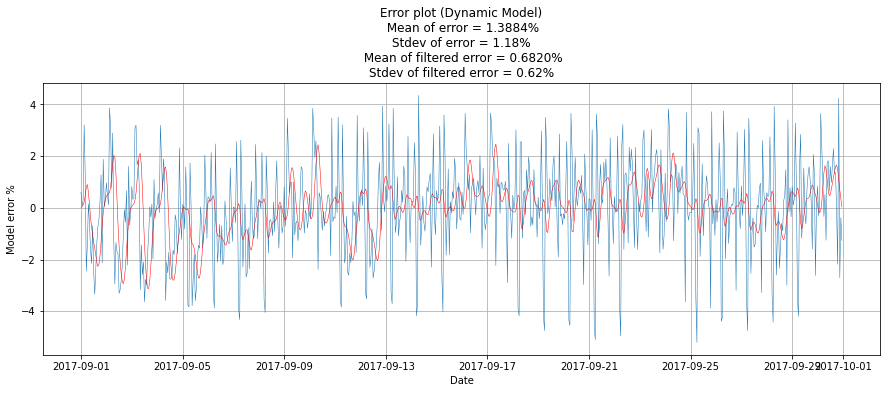

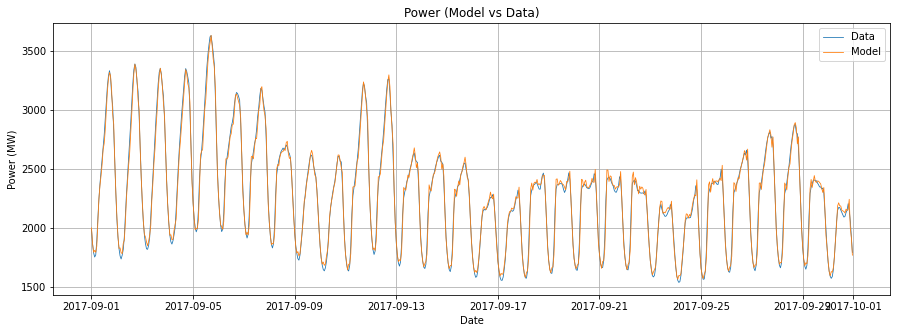

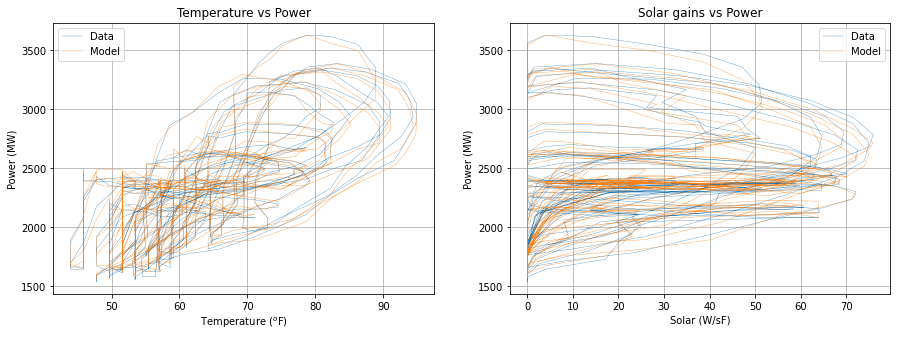

MODEL PARAMETERS
Months divisor: 4
Days divisor: 1
Hours divisor: 8
Model order: 3
Hold out data: 2.75 %


TransferFunction(array([ 0.85478624,  1.62450046, -4.33548987,  1.56059769]), array([ 0.34265034, -1.23680414,  1.84975042]), 1)

In [83]:
features_model('feeder_power.csv', 'feeder_weather.csv', feeder.power, model_order = 3)

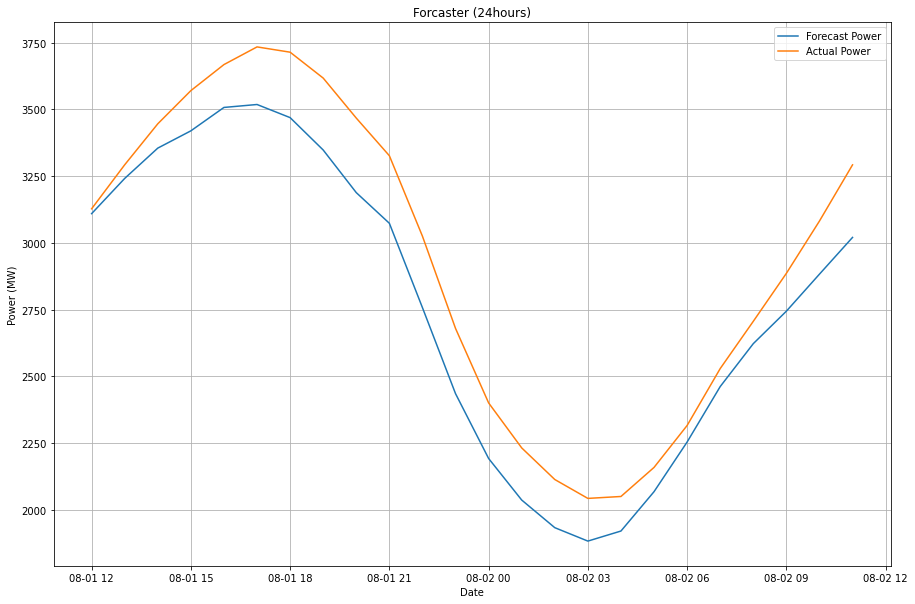

In [16]:
# forecaster 

t0 = feeder[feeder.temperature == feeder.temperature.max()].index.to_pydatetime()[0] - timedelta(hours = 24)
hours = 24

def forecast(dataframe, t0, dt, nt): 
    k = nt
    L = nt+1
    K = len(dataframe.power)
    N = int(len(dataframe)*0.0275)
    P = matrix(dataframe.power).transpose()
    T = matrix(dataframe.temperature).transpose()
    M_k = np.hstack([np.hstack([P[n:K-L+n] for n in list(reversed(range(L)))]),
                 np.hstack([T[n:K-L+n] for n in list(reversed(range(L+1)))])])
   
    P = dataframe.power    
    T = dataframe.temperature
    i = 0    
    yy = [] 
    p = P[t0 - L*dt:t0 - dt].tolist()
    for t in date_range(t0,t0+dt*(nt-1),nt):
        M = M_k[:,i:]
        Mh = M[0:-N]
        Mt = Mh.transpose()
        x = np.linalg.solve(np.matmul(Mt,Mh),np.matmul(Mt,P[L:-N]))
        M_forc = hstack([list(reversed(p)),list(reversed(T[t - L*dt:t]))])
        y = matmul(M_forc,x)
        yy.append(y)  
        p = p[1:]
        i = i+1

    result = DataFrame(yy,date_range(t0,t0+dt*(nt-1),nt), columns=['forecast'])
    result.index.name = 'datetime'
    return result

R = forecast(feeder, t0,timedelta(hours=1),hours).join(feeder.power)
figure(3,figsize = (15,10))
plot(R.index,R.forecast, label = 'Forecast Power')
plot(R.index,R.power, label = 'Actual Power')
xlabel("Date")
ylabel("Power (MW)")
title("Forcaster (24hours)")
legend()
grid()
show()

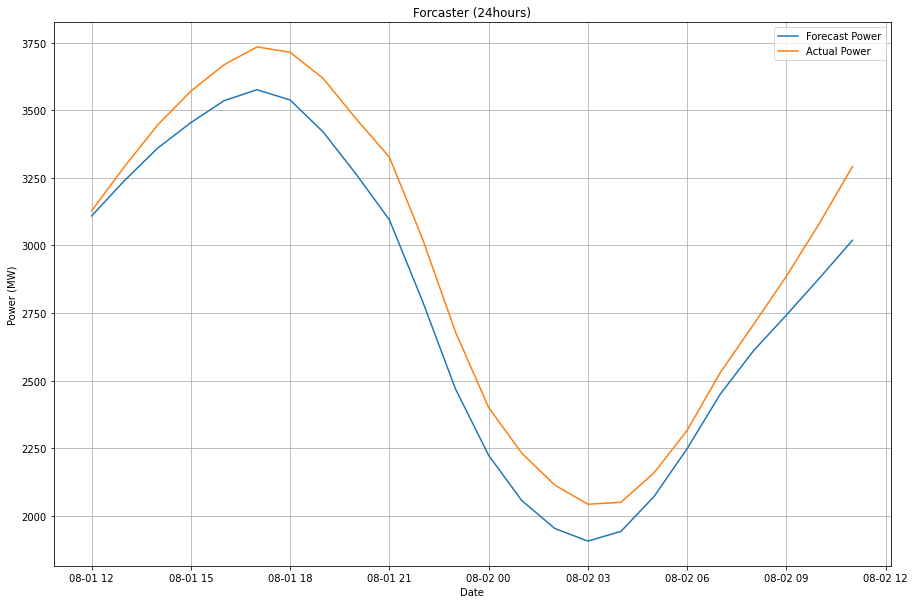

In [17]:
M_order = 24
L = 24

K = len(feeder.power)
P = matrix(feeder.power).transpose()
T = matrix(feeder.temperature).transpose()
S = matrix(feeder.solar).transpose()

A = np.hstack([np.hstack([T[n:K-(M_order+L)+n] for n in range(M_order+1)]),
               np.hstack([P[n:K-(M_order+L)+n] for n in range(M_order+L)])])
M = A[:,0:-L]
Mh = M
Mt = Mh.transpose()
Y = A[:,-L:]
f = np.linalg.solve(np.matmul(Mt,Mh),np.matmul(Mt,Y))

# forecaster 
t0 = feeder[feeder.temperature == feeder.temperature.max()].index.to_pydatetime()[0] - timedelta(hours = 24)
hours = L
def forecast(sys, dataframe, t0, dt, nt):   
    M = (len(sys)-1)/2
    P = dataframe.power
    T = dataframe.temperature
    i = 0    
    yy = [] 
    p = P[t0 - M*dt:t0 - dt].tolist()
    for t in date_range(t0,t0+dt*(nt-1),nt):
        x = sys[:,i]
        M_forc = hstack([T[t0 - M*dt:t0],p])
        y = matmul(M_forc,x)
        yy.append(y)  
        i = i+1

    result = DataFrame(np.reshape(yy,(nt,1)),date_range(t0,t0+dt*(nt-1),nt), columns=['forecast'])
    result.index.name = 'datetime'
    return result

R = forecast(f,feeder, t0,timedelta(hours=1),hours).join(feeder.power)
figure(3,figsize = (15,10))
plot(R.index,R.forecast, label = 'Forecast Power')
plot(R.index,R.power, label = 'Actual Power')
xlabel("Date")
ylabel("Power (MW)")
title("Forcaster (24hours)")
legend()
grid()
show()


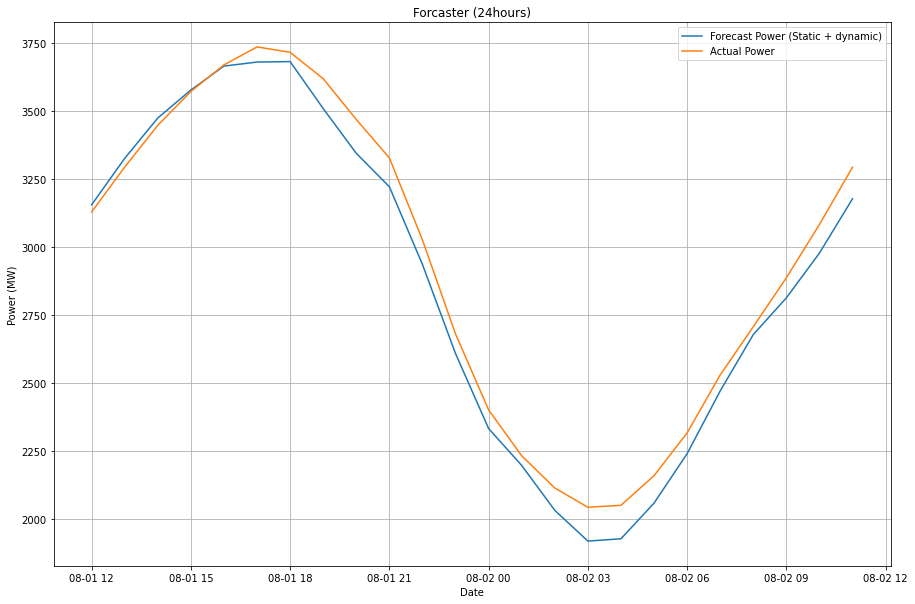

In [18]:
# forecaster for static power

M_order = 24
L = 24 

K = len(feeder.power)
P = matrix(feeder.P_residual).transpose()
T = matrix(feeder.temperature).transpose()
S = matrix(feeder.solar).transpose()

A = np.hstack([np.hstack([T[n:K-(M_order+L)+n] for n in range(M_order+1)]),
               np.hstack([P[n:K-(M_order+L)+n] for n in range(M_order+L)])])

M = A[:,0:-L]
Mh = M
Mt = Mh.transpose()
Y = A[:,-L:]
f = np.linalg.solve(np.matmul(Mt,Mh),np.matmul(Mt,Y))

# forecaster 
t0 = feeder[feeder.temperature == feeder.temperature.max()].index.to_pydatetime()[0] - timedelta(hours = 24)
hours = L
def forecast(sys, dataframe, t0, dt, nt):   
    M = 24
    P = dataframe.P_residual
    T = dataframe.temperature
    S = dataframe.solar
    i = 0    
    yy = [] 
    p = P[t0 - M*dt:t0 - dt].tolist()
    for t in date_range(t0,t0+dt*(nt-1),nt):
        x = sys[:,i]
        M_forc = hstack([T[t0 - M*dt:t0],p])
        y = matmul(M_forc,x)
        yy.append(y)  
        i = i+1

    result = DataFrame(np.reshape(yy,(nt,1)),date_range(t0,t0+dt*(nt-1),nt), columns=['forecast'])
    result.index.name = 'datetime'
    return result

R = forecast(f,feeder, t0,timedelta(hours=1),hours).join(feeder.power).join(feeder.P_static).join(feeder.P_residual)
figure(3,figsize = (15,10))

# plot(R.index,R.P_static, '--r',label = 'Static Power')
# plot(R.index,R.forecast, '--m', label = 'Forecast dynamic Power')
# plot(R.index,R.P_residual, 'k',label = 'Actual dynamic Power')
plot(R.index,(R.P_static+R.forecast), label = 'Forecast Power (Static + dynamic)')
plot(R.index,R.power, label = 'Actual Power')

xlabel("Date")
ylabel("Power (MW)")
title("Forcaster (24hours)")
legend()
grid()
show()
